<a href="https://colab.research.google.com/github/RodrigoLauro/RodrigoLauro-CEIA-20254BI-NLP1/blob/main/Desafio_3_Lauro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio 3: Modelo de Lenguaje a Nivel Carácter

Alumno: Rodrigo Lauro
Materia: Procesamiento de Lenguaje Natural – CEIA FIUBA

Texto utilizado: El Príncipe – Nicolás Maquiavelo

En este trabajo se entrena un modelo de lenguaje basado en RNN (SimpleRNN) para predecir el próximo carácter de un texto. El objetivo es comprender:

Construcción de corpus

Tokenización a nivel carácter

Generación de secuencias de entrenamiento (many-to-many)

Entrenamiento con RNN

Métrica de Perplejidad

Generación de texto usando Greedy y Beam Search

In [ ]:
import numpy as np
import urllib.request
import bs4 as bs
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, TimeDistributed
from keras.layers import CategoryEncoding
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax


## Carga del corpus
Descargamos la obra *El Príncipe* desde textos.info y extraemos los párrafos.

Realizamos:
- concatenación del texto,
- conversión a minúsculas,
- análisis de caracteres únicos.


In [ ]:
# Cargar el texto del Príncipe
raw_html = urllib.request.urlopen('https://www.textos.info/nicolas-maquiavelo/el-principe/ebook').read()
article_html = bs.BeautifulSoup(raw_html, 'lxml')
paragraphs = article_html.find_all('p')

article_text = ''
for p in paragraphs:
    article_text += p.text + ' '

article_text = article_text.lower()

len(article_text), article_text[:500]


(181902,
 ' nicolas maquiavelo,\r\nciudadano y secretario de florencia,\r\nal\r\nmagnífico señor\r\nlorenzo de medicis,\r\nduque de urbino, señor de pésaro,\r\netc. etc. los que desean captarse la voluntad de un príncipe suelen\r\nofrecerle presentes de raro mérito, o aquellas cosas que son\r\nconocidamente de su agrado: unos le presentan armas o caballos, otros\r\ntelas de oro, piedras preciosas, alhajas, en fin, dignas de su grandeza.\r\ndeseando yo, pues, ofreceros una prueba de mi adhesión y respetuosa\r\nobediencia, he enc')

## Construcción del vocabulario
Convertimos el texto en un conjunto de caracteres únicos. Luego definimos:

- `char2idx`: mapea carácter → índice
- `idx2char`: mapea índice → carácter

También tokenizamos TODO el corpus.


In [ ]:
chars_vocab = sorted(list(set(article_text)))
vocab_size = len(chars_vocab)

char2idx = {c:i for i,c in enumerate(chars_vocab)}
idx2char = {i:c for c,i in char2idx.items()}

tokenized_text = [char2idx[ch] for ch in article_text]

vocab_size, len(tokenized_text)


(61, 181902)

## Generación de secuencias
Usamos ventanas deslizantes de tamaño `100`.  
Para cada ventana:
- X: secuencia de entrada
- y: secuencia desplazada en +1 posición

Este es el enfoque **many-to-many**, que produce un gradiente por cada carácter.


In [ ]:
max_context_size = 100

# División train / val
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val / max_context_size))

train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

# Secuencias de validación
tokenized_sentences_val = [
    val_text[i*max_context_size : (i+1)*max_context_size]
    for i in range(num_val)
]

# Secuencias sliding window para training
tokenized_sentences_train = [
    train_text[i : i+max_context_size]
    for i in range(len(train_text)-max_context_size)
]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

X.shape, y.shape


((163601, 100), (163601, 100))

## Definición del modelo

### Arquitectura propuesta

- Capa de entrada: indices de caracteres → One-Hot (CategoryEncoding + TimeDistributed)  
- Capa recurrente: `SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)`  
- Capa de salida: `Dense(vocab_size, activation='softmax)`  


El modelo aprende a predecir el próximo carácter a partir del estado oculto.

In [ ]:
model = Sequential()
model.add(TimeDistributed(
            CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
            input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 61)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 61)       │        12,261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,661 (252.58 KB)

 Trainable params: 64,661 (252.58 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Callback para calcular perplejidad (validación)
Como Keras no ofrece perplejidad nativamente, implementamos un Callback que:

- calcula perplejidad al final de cada epoch
- guarda el mejor modelo (`my_model.keras`)
- aplica early stopping


In [ ]:
class PplCallback(keras.callbacks.Callback):

    def __init__(self, val_data, history_ppl, patience=5):
        self.val_data = val_data
        self.history_ppl = history_ppl
        self.patience = patience
        self.patience_counter = 0
        self.min_score = np.inf

        self.target = []
        self.padded = []
        count = 0
        self.info = []

        for seq in self.val_data:
            L = len(seq)
            subseq = [seq[:i] for i in range(1, L)]
            self.target.extend([seq[i] for i in range(1, L)])

            if len(subseq) > 0:
                self.padded.append(pad_sequences(subseq, max_context_size, padding='pre'))
                self.info.append((count, count+L))
                count += L

        self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.padded, verbose=0)
        scores = []

        for start, end in self.info:
            probs = [
                preds[idx_seq, -1, idx_vocab]
                for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])
            ]
            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

        score = np.mean(scores)
        self.history_ppl.append(score)
        print(f"\nPerplexity: {score}\n")

        if score < self.min_score:
            self.min_score = score
            self.model.save("my_model.keras")
            print("Saved best model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Early stopping.")
                self.model.stop_training = True


## Entrenamiento del modelo
# Entrenamos durante 20 epochs y graficamos perplejidad.


In [ ]:
history_ppl = []
hist = model.fit(X, y, epochs=20 , batch_size=256,
                 callbacks=[PplCallback(tokenized_sentences_val, history_ppl)])


Epoch 1/20
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 2.5414
Perplexity: 7.583648767445114

Saved best model!
640/640 ━━━━━━━━━━━━━━━━━━━━ 239s 363ms/step - loss: 2.5405
Epoch 2/20
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 1.9745
Perplexity: 6.403022012212774

Saved best model!
640/640 ━━━━━━━━━━━━━━━━━━━━ 224s 350ms/step - loss: 1.9743
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 1.8268
Perplexity: 5.923061059071467

Saved best model!
640/640 ━━━━━━━━━━━━━━━━━━━━ 268s 360ms/step - loss: 1.8268
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 1.7443
Perplexity: 5.6524276962647075

Saved best model!
640/640 ━━━━━━━━━━━━━━━━━━━━ 228s 356ms/step - loss: 1.7442
Epoch 5/20
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 1.6939
Perplexity: 5.504278120103773

Saved best model!
640/640 ━━━━━━━━━━━━━━━━━━━━ 226s 353ms/step - loss: 1.6938
Epoch 6/20
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 1.6600
Perplexity: 5.481296359182714

Saved bes

## Evolución de la perplejidad


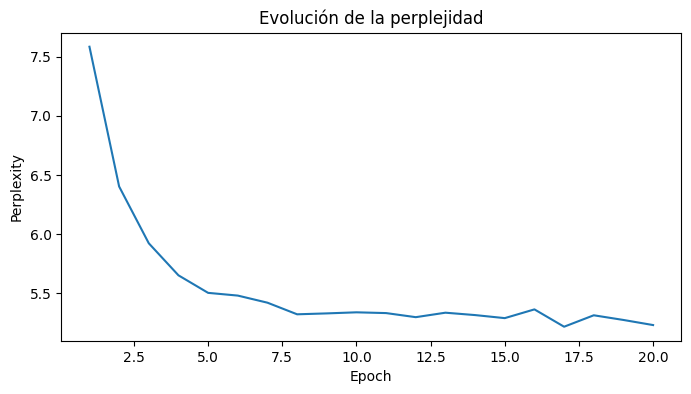

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, len(history_ppl)+1), y=history_ppl)
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Evolución de la perplejidad")
plt.show()


Cargamos el mejor modelo

In [ ]:
model = keras.models.load_model("my_model.keras")


### Generación de texto
## Greedy


In [ ]:
def generate_seq(model, seed_text, max_length, n_chars):
    output = seed_text

    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output.lower()]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        y_hat = np.argmax(model.predict(encoded, verbose=0)[0, -1, :])
        output += idx2char[y_hat]

    return output




### Generación con Greedy Search

Usamos la función `generate_seq` que, en cada paso, elige el carácter con mayor probabilidad (`argmax`). Esto tiende a generar texto coherente pero a veces repetitivo y poco diverso.


In [ ]:
generate_seq(model, "el prin", max_context_size, 200)

'el principado con la mismo tiempo de su partido más al pueblo para conservar a su partido más al pueblo para conservar a su partido más al pueblo para conservar a su partido más al pueblo para conservar a su'

## Generación de texto
## Beam Search

In [ ]:
def encode(text,max_length=max_context_size):
    encoded = [char2idx[ch] for ch in text]
    return pad_sequences([encoded], maxlen=max_length, padding='pre')

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):
    pred_large = []
    for idx,pp in enumerate(pred):
        pred_large.extend(np.log(pp+1E-10)+history_probs[idx])
    pred_large = np.array(pred_large)

    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams,
                                      p=softmax(pred_large/temp))
    else:
        raise ValueError()

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select//vocab_size],
         np.array([idx_select%vocab_size]).T), axis=1)

    return pred_large[idx_select], new_history_tokens.astype(int)

def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    encoded = encode(input)
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]
    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size,
        history_probs, history_tokens, temp, mode)

    for i in range(num_words-1):
        preds = []
        for hist in history_tokens:
            input_update = np.array([hist[i+1:]]).copy()
            y_hat = model.predict(input_update,verbose=0)[0,-1,:]
            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size,
            history_probs, history_tokens, temp, mode)

    return history_tokens[:,-(len(input)+num_words):]


### Generación con Beam Search Determinístico
Eso es beam search determinístico (mode='det').

In [ ]:
result = beam_search(model, num_beams=5, num_words=200, input="el prin", temp=1, mode='det')
decode(result[0])

'el principado de sus súbditos que se había de sus súbditos que se había de sus súbditos que se había de sus súbditos que se había de sus súbditos que se había de sus súbditos que se había de sus súbditos de '

### Generación con Beam Search Estocástico
Eso es Beam search  + temperatura

In [ ]:
# Beam search estocástico, temperatura baja (más conservador)
result_sto_t08 = beam_search(model, num_beams=5, num_words=200, input="el prin", temp=0.8, mode='sto')
print("Beam estocástico temp=0.8:\n", decode(result_sto_t08[0]))

# Beam search estocástico, temperatura media
result_sto_t12 = beam_search(model, num_beams=5, num_words=200, input="el prin", temp=1, mode='sto')
print("\nBeam estocástico temp=1:\n", decode(result_sto_t12[0]))

# Beam search estocástico, temperatura alta (más creativo / caótico)
#result_sto_t12 = beam_search(model, num_beams=5, num_words=200, input="el prin", temp=1.2, mode='sto')
#print("\nBeam estocástico temp=1.2:\n", decode(result_sto_t12[0]))


# Beam search estocástico, temperatura altasimo . Delira
#result_sto_t12 = beam_search(model, num_beams=5, num_words=200, input="el prin", temp=2, mode='sto')
#print("\nBeam estocástico temp=2:\n", decode(result_sto_t12[0]))


# Beam search estocástico, temperatura baja (más conservador)- Mas Beams
result_sto_t08 = beam_search(model, num_beams=20, num_words=200, input="el prin", temp=0.8, mode='sto')
print("Beam estocástico temp=0.8:\n beams=20", decode(result_sto_t08[0]))


# Beam search estocástico, temperatura alta (más creativo / caótico) Mas Beams
result_sto_t12 = beam_search(model, num_beams=20, num_words=200, input="el prin", temp=1.2, mode='sto')
print("\nBeam estocástico temp=1.2:\n beams=20", decode(result_sto_t12[0]))



Beam estocástico temp=0.8:
 el principado con la mismo tiempo nuevo ser príncipe que se había conocimiento de la mantener a la impresión de sus provincias de la mismo mantenerse a la seguridad que se había contra la conducta de la regu

Beam estocástico temp=1:
 el principado con la guerra mantener a sus mismo tiene para mantenerse el cual pueblo que se había hacer de estos cardenes de estado a la mantenerse a la de estado el pueblo de la conducto a la fuerza, y no 

Beam estocástico temp=1.2:
 el principado de la mismo para mantenerse a la liberal a contrario, por un príncipe nuevo se había con su partido más presentar el mismo para más que la cierta la impresión que se expone de
los mismo tiempo

Beam estocástico temp=2:
 el principado más carácta a alamirse
adquiria de la mator príncipe malos experimontrarle de
habífeson una maneles,
las propiados manda
redellos por su esmo, pero para facultad, sur propurar de la manten«
Beam estocástico temp=0.8:
 beams=20 el principado de la mismo

In [ ]:
# Beam search estocástico, temperatura baja (más conservador)- Mas Beams
result_sto_t08 = beam_search(model, num_beams=50, num_words=200, input="el prin", temp=0.8, mode='sto')
print("Beam estocástico temp=0.8:\n beams=50", decode(result_sto_t08[0]))


# Beam search estocástico, temperatura alta (más creativo / caótico) Mas Beams
result_sto_t12 = beam_search(model, num_beams=50, num_words=200, input="el prin", temp=1.2, mode='sto')
print("\nBeam estocástico temp=1.2:\n beams=50", decode(result_sto_t12[0]))

Beam estocástico temp=0.8:
 beams=50 el principado de sus súbditos que se mantenerse a la mismo tiempo de sus súbditos que se hubieran para mantenerse en el príncipe nuevo que se había de sus súbditos que se había de sus súbditos que se había c

Beam estocástico temp=1.2:
 beams=50 el principado también que se hubieran para mantenerse a la mismo tiempo de sus súbditos que se había de sus súbditos que se había de sus súbditos que el príncipe que se había de sus súbditos que se había con


# Conclusiones

- El modelo aprende patrones estilísticos del texto de Maquiavelo.
- La perplejidad disminuye hasta cierto punto, mostrando aprendizaje real.
- El método greedy tiende a repetir frases y generar texto plano.
- Beam search produce resultados mucho más coherentes.
- El tamaño del contexto y la cantidad de unidades de la RNN afectan claramente la calidad.

Comparé Greedy Search, Beam Search determinístico y Beam Search estocástico.
 - Greedy Search siempre elige el carácter más probable y genera texto coherente pero repetitivo y poco variado.

 - Beam Search determinístico mantiene varias secuencias candidatas y selecciona la más probable en conjunto; fue el método que produjo el texto más coherente, fluido y estable, sin repeticiones.

 - Beam Search estocástico, usando temperatura, permitió introducir variación y creatividad: con temperaturas bajas mantiene coherencia similar al determinístico, mientras que con temperaturas altas genera texto más diverso pero menos preciso. Un numero mas alto de Beans nos mantiene secuencias mas largas, pero hace mas lento el reproceso y no evidencia demasiada mejora.
